In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 08 - Other Regressions

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import Statements
###------------------
import sys
import os
import datetime
import numpy as np
import pandas as pd


import matplotlib
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler

from scipy import stats

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, ElasticNet, ElasticNetCV

In [3]:
###----------------------
### Some Basic Parameters
###----------------------

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg

plt.rcParams.update(params);

plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

<Figure size 1500x500 with 0 Axes>

## k-neighbors Regression

### Determine your distance metrics

**Euclidean distance (p = 2)** between two input vectors $X_r$ and $X_s$

$d(X_r , X_s ) =|| X_r - X_s ||^2=\sqrt{\sum_{i=1}^n{\biggl((x_r^i-x_s^i)^2 \biggr)}}$


Given that the K-NN method is dependent on distance measures, it is
recommended that the input data be standardized first before proceeding to build
an optimal K-NN model.

<img src='../../images/knn_vector.png' alt = 'model_complexity' width=400px />

**Manhattan distance (p=1)** is the absolute value between two points.I t is commonly visualized with a grid, illustrating how one might navigate from one address to another along the grid.

$d(X_r , X_s ) =| X_r - X_s |=\sum_{i=1}^n{|x_r^i-x_s^i|}$

**Minkowski distance:** is the generalized form of Euclidean and Manhattan distance metrics. The parameter, p, in the formula below, allows for the creation of other distance metrics. Euclidean distance is represented by this formula when p is equal to two, and Manhattan distance is denoted with p equal to one.

$d(X_r , X_s ) =| X_r - X_s |^{(\frac{1}{p})}=\biggl({\sum_{i=1}^n|x_r^i-x_s^i| }\biggr)^{(\frac{1}{p})}$



**Hamming distance:** is used typically used with Boolean or string vectors, identifying the points where the vectors do not match. As a result, it has also been referred to as the overlap metric. This can be represented with the following formula:

$\begin{equation}
    D_h=\sum_{i=1}^n|x_r^i-x_s^i|\\
    \text{Where }d_h^i =
    \begin{cases}
      0, & \text{if}\ x_r^i=x_s^i \\
      1, & \text{otherwise}\}
    \end{cases}
  \end{equation}$
  
  <img src='../../images/hamming_distance.png' alt = 'Figure hamming distance' width=500px />
  
  

## Weighted averages
The algorithm assigns weights to the neighbors based on their proximity or inverse distance to the input data point. The `closer` neighbors may have higher weights, indicating their stronger influence on the prediction.

The `weighted average` is calculated by summing up the product of each neighbor's target value and its corresponding weight, then dividing by the sum of the weights.

$
\begin{align}
\text{For K = 1: } & \hat{y}^{(1)} = y_1\\
\\
\text{For K = 2: } & \hat{y}^{(2)} = \frac{\frac {1}{d_1}.y_1 + \frac {1}{d_2}.y_2}{\frac {1}{d_1} + \frac {1}{d_2}}\\
\\
\text{For K = 3: } & \hat{y}^{(3)} = \frac{\frac {1}{d_1}.y_1 + \frac {1}{d_2}.y_2 + \frac {1}{d_3}.y_3}{\frac {1}{d_1} + \frac {1}{d_2} + \frac {1}{d_3}}\\
\vdots & \vdots\\
\text{For K = n: } & \hat{y}^{(n)} = \frac{\frac {1}{d_1}.y_1 + \frac {1}{d_2}.y_2 \cdots + \frac {1}{d_n}.y_n}{\frac {1}{d_1} + \frac {1}{d_2} \cdots + \frac {1}{d_n}}\\
\end{align}
$

where $d_i$ is distance of prediction from the $i^{th}$ neighbor. 

In [4]:
def fn_make_wave(n_samples=100):
    '''
    Args:
        n_samples : int, number of samples
        
    Returns:
        x: np.ndarray colomn veactor with n_sample values
        y: np.ndarray labels
    '''
    
    # instantiate random state
    rnd = np.random.RandomState(RANDOM_STATE)
    
    # generate n_samples
    x = rnd.uniform(-3, 3, size=n_samples)
    
    # generate y 
    y_no_noise = (np.sin(4 * x) + x)
    
    # add some noise
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    
    return x.reshape(-1, 1), y

In [5]:
#  3-color colormap

#from matplotlib.colors import ListedColormap #, colorConverter, LinearSegmentedColormap

#cm_3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import euclidean_distances
from sklearn.model_selection import train_test_split

n_neighbors=1

#Create a dataset
X, y = fn_make_wave(n_samples=100)

# split in train and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    random_state=RANDOM_STATE,
                                                    test_size = 4 )

# calculate Euclidean Distance
dist = euclidean_distances(X_train, X_test)

# who is closest?
closest = np.argsort(dist, axis=0)

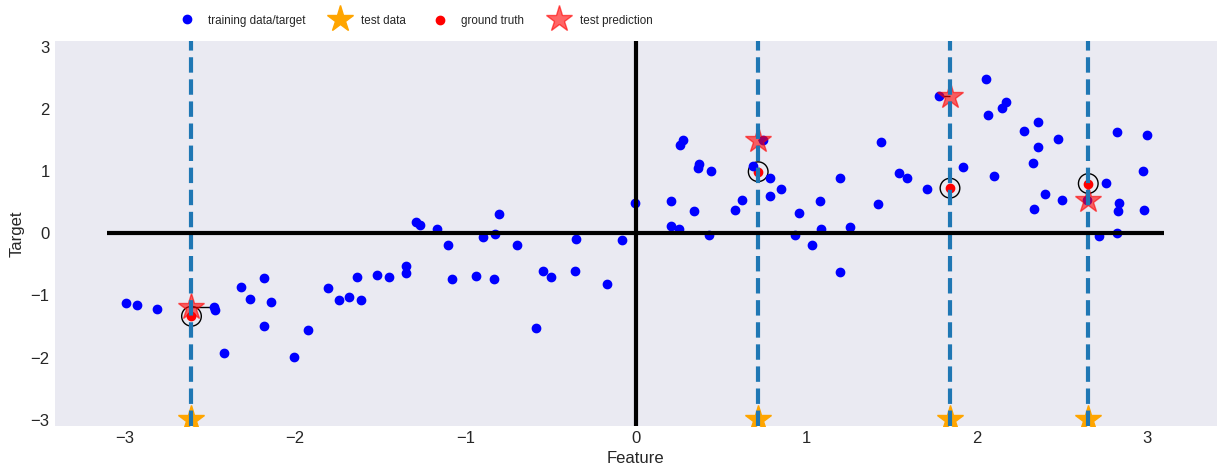

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import euclidean_distances
from sklearn.model_selection import train_test_split

n_neighbors=1

#Create a dataset
X, y = fn_make_wave(n_samples=100)

# split in train and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    random_state=RANDOM_STATE,
                                                    test_size = 4 )

# calculate Euclidean Distance
dist = euclidean_distances(X_train, X_test)

# who is closest?
closest = np.argsort(dist, axis=0)

#Instantiate a Regressor and train
reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)

# make predictions
y_pred = reg.predict(X_test)

# instantiate a plot
fig, ax = plt.subplots()

# plot training data
train, = ax.plot(X_train, y_train, 'o', c='b')

test, = ax.plot(X_test, -3 * np.ones(len(X_test)), '*', c='orange',
                 markersize=20)

pred, = ax.plot(X_test, y_pred, '*', c='r', markersize=20, alpha = 0.6)


# little decorations
ax.vlines(X_test, -3.1, 3.1, linestyle="--", linewidth = 3)

ax.vlines(0, -3.1, 3.1, color='k', linewidth = 3)

ax.hlines(0, -3.1, 3.1, color='k', linewidth = 3)

# Connect between nearest neighbor and prediction
for x, y_, neighbors in zip(X_test, y_pred, closest.T):
    
    for neighbor in neighbors[:n_neighbors]:
        
        plt.arrow(x[0], y_, 
                  X_train[neighbor, 0] - x[0], 
                  y_train[neighbor] - y_,
                  head_width=0, 
                  fc='k', ec='k')
        
gt = ax.scatter(X_test[:, 0], 
            y_test, edgecolors='r', 
            facecolor = 'r');

ax.scatter(X_test[:, 0], 
            y_test, s=200, edgecolors='k', 
            facecolor = 'none');

ax.legend([train, test, gt, pred],
           ["training data/target", "test data", "ground truth", "test prediction"],
           ncol=4, loc=(.1, 1.025))

ax.set_ylim(-3.1, 3.1)

ax.set_xlabel("Feature")

ax.set_ylabel("Target")

plt.grid()

### Take 3 Neighbors

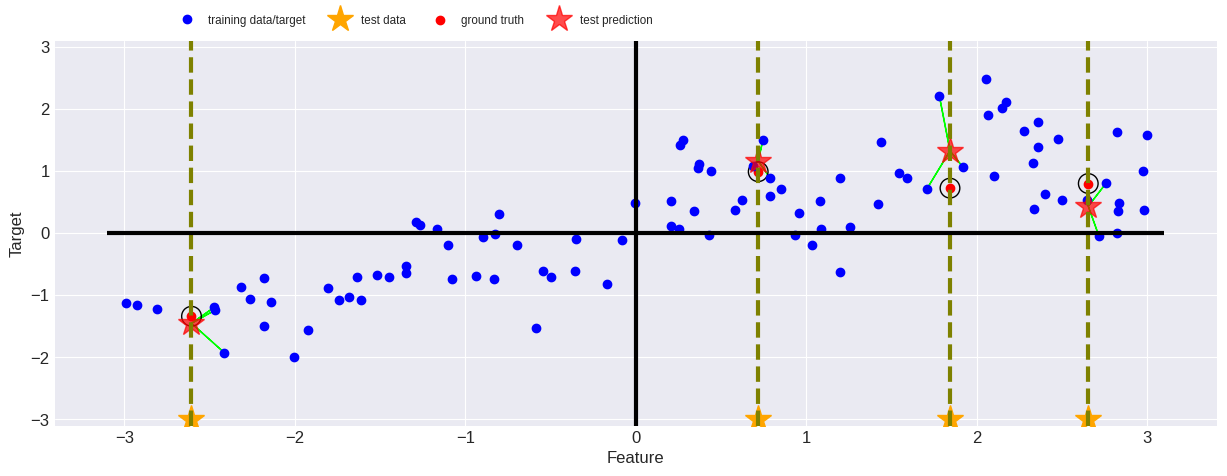

In [8]:
n_neighbors=3

#Instantiate a Regressor and train
reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)

# make predictions
y_pred = reg.predict(X_test)


# calculate Euclidean Distance
dist = euclidean_distances(X_train, X_test)

# who is closest?
closest = np.argsort(dist, axis=0)

# instantiate a plot
fig, ax = plt.subplots()

colors = CMAP(np.linspace(0,1,5))


# plot training data
train, = ax.plot(X_train, y_train, 'o', c='b')

test, = ax.plot(X_test, -3 * np.ones(len(X_test)), '*', c='orange',
                 markersize=20)

pred, = ax.plot(X_test, y_pred, '*', c='r', markersize=20, alpha = 0.7)


# little decorations
ax.vlines(X_test, -3.1, 3.1, linestyle="--", linewidth = 3, color = colors[3])

ax.vlines(0, -3.1, 3.1, color='k', linewidth = 3)

ax.hlines(0, -3.1, 3.1, color='k', linewidth = 3)

# Connect between nearest neighbor and prediction
for x, y_, neighbors in zip(X_test, y_pred, closest.T):

    for neighbor in neighbors[:n_neighbors]:
        
        plt.arrow(x[0], y_,
                  X_train[neighbor, 0] - x[0], 
                  y_train[neighbor] - y_,
                  head_width=0, 
                  fc=colors[4], ec=colors[4])
            
gt = ax.scatter(X_test[:, 0], 
            y_test, edgecolors='r', facecolor = 'r');

ax.scatter(X_test[:, 0], 
            y_test,
           s=200, edgecolors='k', facecolor = 'none');


ax.legend([train, test, gt, pred],
           ["training data/target", "test data", "ground truth", "test prediction"],
           ncol=4, loc=(.1, 1.025))

ax.set_ylim(-3.1, 3.1)

ax.set_xlabel("Feature")

ax.set_ylabel("Target");

## Tracking some matrix

Once again we will initialize data and this time keep reasonable test size.

In [9]:
X, y = fn_make_wave(n_samples=100)

# split the wave dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# instantiate the model and set the number of neighbors to consider to 3
reg = KNeighborsRegressor(n_neighbors=3)

# fit the model using the training data and training targets
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_pred

array([ 0.43230492,  1.16395412,  1.16023329, -1.4446796 ,  0.85247108,
        0.66803064, -1.32898735,  0.8373265 ,  1.64447128, -0.61931137,
        1.18685119, -1.39261458,  0.47768419, -0.50375078,  0.66472584,
       -0.09853916,  1.64447128,  1.17561739,  0.96715476, -0.16702337])

 ### R-squared
R-squared $R^2$ = 1-$\frac{SS_{res}}{SS_{tot}}$
Where $SS_{res}$ = sum of square of residuals,
and $SS_{tot}$ = Total sum of squares

$
\begin{align}
SS_{res} = \sum\limits_{i=1} ^{n}{({y_i-\hat{y}_i})^2}\\
SS_{tot} = \sum\limits_{i=1} ^{n}{({y_i-\bar{y}})^2}\\
\end{align}
$

**where:** $\hat{y}_i$ is prediction and $\bar{y}$ is mean.

Best values will be 1.0 and worst be 0.0.

In [10]:
print(r"Test set R^2: {:.2f}".format(reg.score(X_test, y_test)))

Test set R^2: 0.80


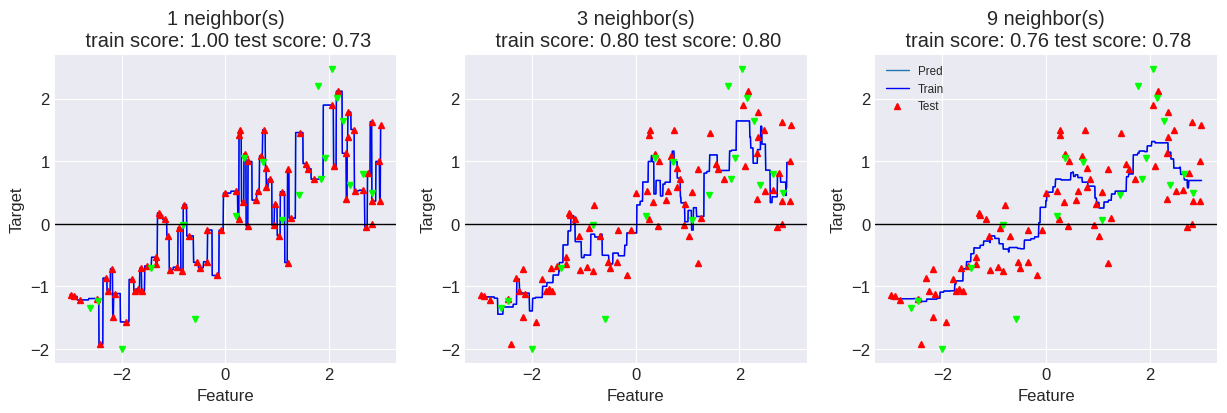

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = CMAP(np.linspace(0,1,3))

# create 1,000 data points, evenly spaced between -3 and 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)

for n_neighbors, ax in zip([1, 3, 9], axes):
    
    # make predictions using 1, 3, or 9 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    # Fit
    reg.fit(X_train, y_train)
    
    # plot predictions
    ax.plot(line, reg.predict(line), )
    
    ax.plot(line, reg.predict(line), c = colors[0])
    
    ax.plot(X_train, y_train, '^',  markersize=4, c = colors[1])
    
    ax.plot(X_test, y_test, 'v', markersize=4, c = colors[2])
    
    ax.axhline(0, c = 'k')
    
    ax.set_title(
        "{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    
    ax.set_xlabel("Feature")
    
    ax.set_ylabel("Target")

plt.legend(["Pred", "Train","Test"], loc="best")

plt.show()

Two important parameters to the KNeighbors classifier: 

- The number of neighbors and 
- How you measure distance between data points.

In practice, using a small number of neighbors like three or five often works well, but you should
certainly **tune** this parameter. 

By default, Euclidean distance is used, which works well in many settings. One should also look at cosine similarity 

**Strength:**
- k-NN is that the model is very easy to understand, and often gives reasonable performance without a lot of adjustments. 

- Gives a good baseline method to try before considering more advanced techniques.

**Weakness**
- Building the nearest neighbors model is usually very fast, but when your training set is very large (either in number of features or in number of samples) prediction can be slow.

- When using the k-NN algorithm, it is important to pre-process your data. However, avoid pre-processing where most features are 0 most of the time (so-called sparse datasets).

So, while the nearest k-neighbors algorithm is easy to understand, it is not often used in practice, due to prediction being slow and its inability to handle many features.

## Regression

Implementations of LinearRegression, LassoRegression and RidgeRegression with appropriate Regularizers and Optimizers.

Linear Regression
- Optimizer: Square Least
- Regularizer: None

Lasso Regression
- Optimizer: Gradient Decent
- Regularizer: L1

Ridge Regression
- Optimizer: Gradient Decent
- Regularizer: L2

## Linear Models
### Linear models for regression
For regression, the general prediction formula for a linear model looks as follows:

$
\begin{align*}
h_\theta(x) = \theta_0 * x_0 + \theta_1 * x_1 + ... + \theta_p * x_p
\end{align*}
$

where $x_0$ = 1.

for single variable 
- Hypothesis : $h_\theta(x) = \theta_0 * x_0 + \theta_1 * x_1$
- Parameters : $\theta_0 , \theta_1$
- Cost Function : $J_\theta(h_\theta(x), y) = \frac{1}{2*m}\sum_{i=1}^m[h_\theta(x^i) -y^i]^2$
- Goal : Minimize $J_\theta(h_\theta(x), y)$

Linear models for regression can be characterized as regression models for which the prediction is a line for a single feature, a plane when using two features, or a hyper‐ plane in higher dimensions (that is, when using more features).

Linear regression, or ordinary least squares (OLS), is the simplest and most classic linear method for regression. Linear regression finds the parameters $\theta$ that minimize the mean squared error between hypothesis (predictions) and the true regression targets, y, on the training set. The mean squared error is the sum of the squared differences between the predictions and the true values, divided by the number of samples. Linear regression has no parameters, which is a benefit, but it also has no way to control model complexity.

In [12]:
def fn_generate_lin_data():
    
    start = -1
    end = 2
    delta = 0.05
    X = np.arange(start, end+ delta, delta)
    
    y_rnd = np.random.rand(X.shape[0])
    y_train = 2* X + y_rnd
    
    y_rnd = np.random.rand(X.shape[0])
    y_test = (2 - y_rnd) * X + y_rnd
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X, y_train)
    ax.scatter(X, y_test, c = 'r')
    ax.axhline(0, c = 'k', lw = 2)
    ax.axvline(0, c = 'k', lw = 2)
    ax.grid()
    return X, X, y_train,  y_test 

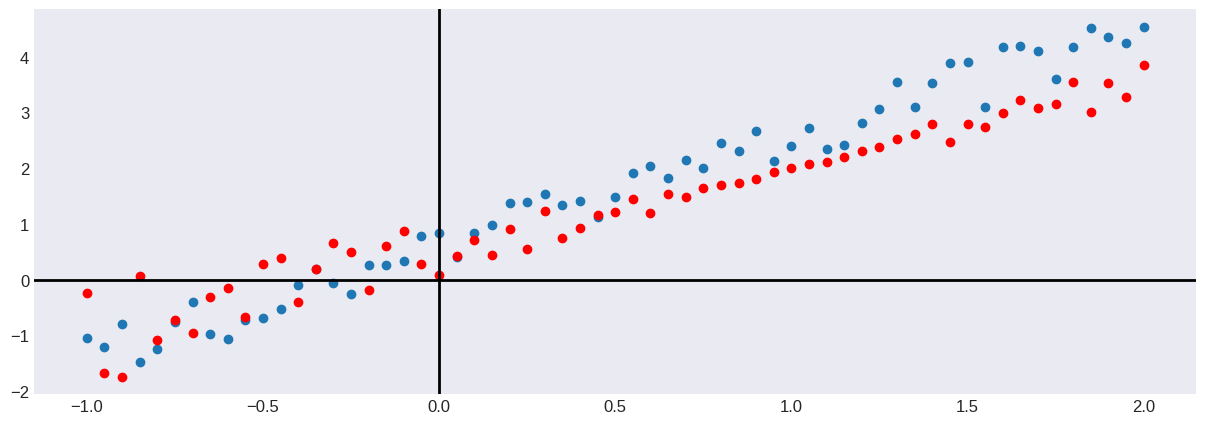

In [13]:
X_train, X_test, y_train,  y_test = fn_generate_lin_data()

In [14]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((61,), (61,), (61,), (61,))

In [15]:
lr = LinearRegression()

lr.fit(X_train.reshape(-1, 1), y_train) # Reshaping x to make it 2D as per SKLearn datastructure

lr.coef_, lr.intercept_

(array([1.99040986]), 0.6044546105188308)

In [16]:
# cross verifying using lin alg

In [17]:
def fn_lin_fit(X_train, y_train, X_test, y_test, nOrder):
    '''
    Args:
        X_train : np.ndarray
        y_train : np.ndarray
        X_test : np.ndarray
        y_test : np.ndarray
        nOrder : order of equation to fit
    '''
    a = np.empty([nOrder,nOrder])
    
    b = np.empty([nOrder])
    
    for i in range(nOrder):
        
        for j in range(nOrder):
            
            a[i,j] = (np.power(X_train, i)*np.power(X_train, j)).sum()
            
            a[j,i] = (np.power(X_train, i)*np.power(X_train, j)).sum()
        
        b[i] = (y_train*np.power(X_train, i)).sum() 

    #print( 'a:',a)
    #print( 'b:',b)    

    sol = np.linalg.solve(a,b)
    
    print ('Solution:', sol)
    
    return sol

In [18]:
orderN = 2

sol = fn_lin_fit(X_train, y_train, X_test, y_test, orderN)

Solution: [0.60445461 1.99040986]


In [19]:
from sklearn.metrics import r2_score

def fn_beautify_plot(ax, y):
    '''
    Args:
        ax : matplotlin axis object
        y: predicted values
    '''
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    # little beautification
    r2_test  =  r2_score(y, y_test)
    r2_train =  r2_score(lr.predict(X_train.reshape(-1, 1)), y_train)

    txtstr = "R2 Scores: \n Training : {:6.3f}\n Testing   : {:6.3f}".format(r2_train,
                                                                          r2_test) #text to plot
    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ymin, ymax = ax.get_ylim()

    ax.vlines(0, ymin, ymax, color= 'k', linewidth = 2)
    ax.hlines(0, X_test.min(), X_test.max(), color= 'k', linewidth = 2)
    ax.grid()

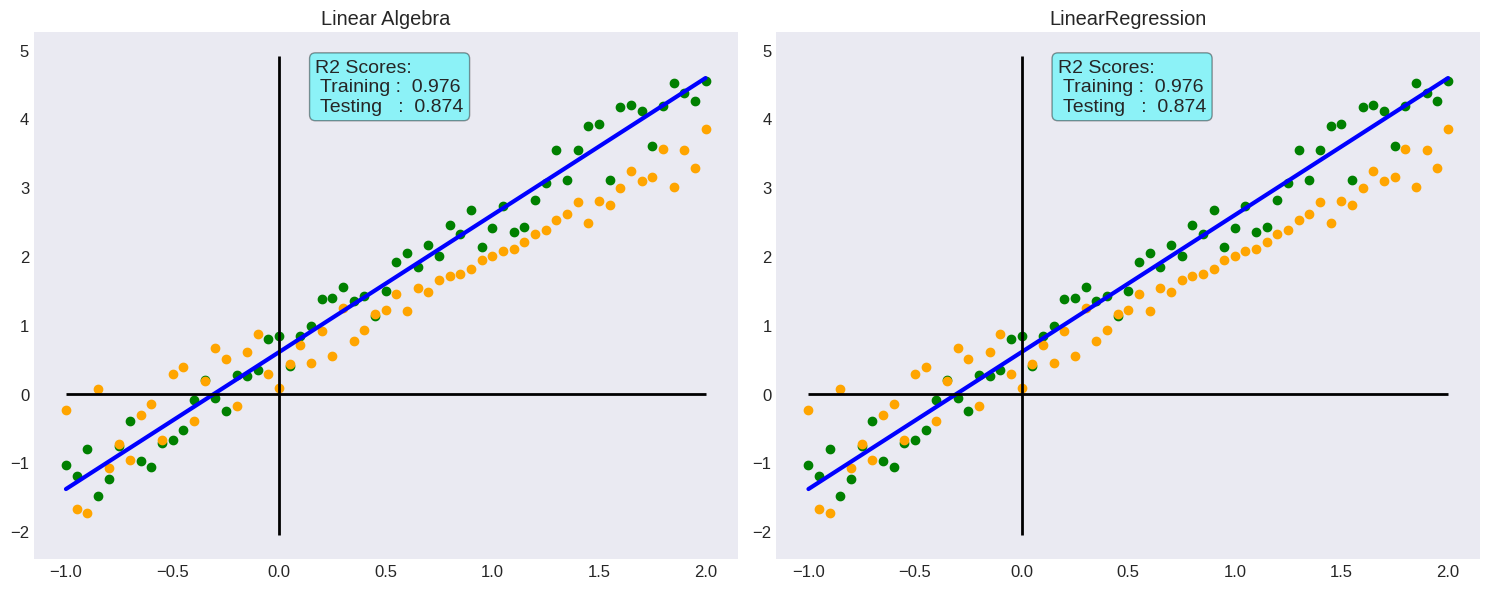

In [20]:
y_pred = lr.predict(X_test.reshape(-1, 1))

y_hat = np.zeros(len(X_test))

for i in range(orderN):

    y_hat  += np.power(X_test, i)*sol[i]

fig, axes = plt.subplots(1,2, figsize = (15,6))

colors = CMAP(np.linspace(0,1,4))

ax = axes[0]
ax.plot(X_test,y_hat , color = 'b', lw = 3)
ax.scatter(X_train, y_train, color = 'g')
ax.scatter(X_test, y_test, color = 'Orange')
fn_beautify_plot(ax, y_hat)
ax.set_title('Linear Algebra')


ax = axes[1]
ax.plot(X_test,y_pred , color = 'b', lw = 3)
ax.scatter(X_train, y_train, color = 'g')
ax.scatter(X_test, y_test, color = 'Orange')
fn_beautify_plot(ax, y_pred)
ax.set_title('LinearRegression')

plt.tight_layout()
plt.show()

## Ridge regression
Ridge regression is also a linear model for regression, so it uses same ordinary least squares. 
In ridge regression,though, the coefficients (w) are chosen not only so that they predict well on the training data, but also to fit an additional constraint.

for single variable 
- Hypothesis : $h_\theta(x) = \theta_0 * x_0 + \theta_1 * x_1$
- Parameters : $\theta_0 , \theta_1, \lambda$
- Cost Function : $J_\theta(h_\theta(x), y) = \frac{1}{2*m}\sum_{i=1}^m[h_\theta(x^i) -y^i]^2 + \lambda * (\theta_1)^2$
- Goal : Minimize $J_\theta(h_\theta(x), y)$

This constraint ($\lambda$)is an example of what is called regularization and determines how severe that penalty is. Regularization means explicitly restricting a model to avoid over-fitting. The particular kind used by ridge regression is known as L2 regularization.

In other words, we are introducing **small bias** to **reduce Variance**.

In [21]:
lr = LinearRegression()

lr.fit(X_train.reshape(-1, 1), y_train) # Reshaping x to make it 2D as per SKLearn datastructure

lr.coef_, lr.intercept_

(array([1.99040986]), 0.6044546105188308)

In [22]:
ridge = Ridge(alpha=10)

ridge.fit(X_train.reshape(-1, 1), y_train)

ridge.coef_, lr.intercept_

(array([1.64289177]), 0.6044546105188308)

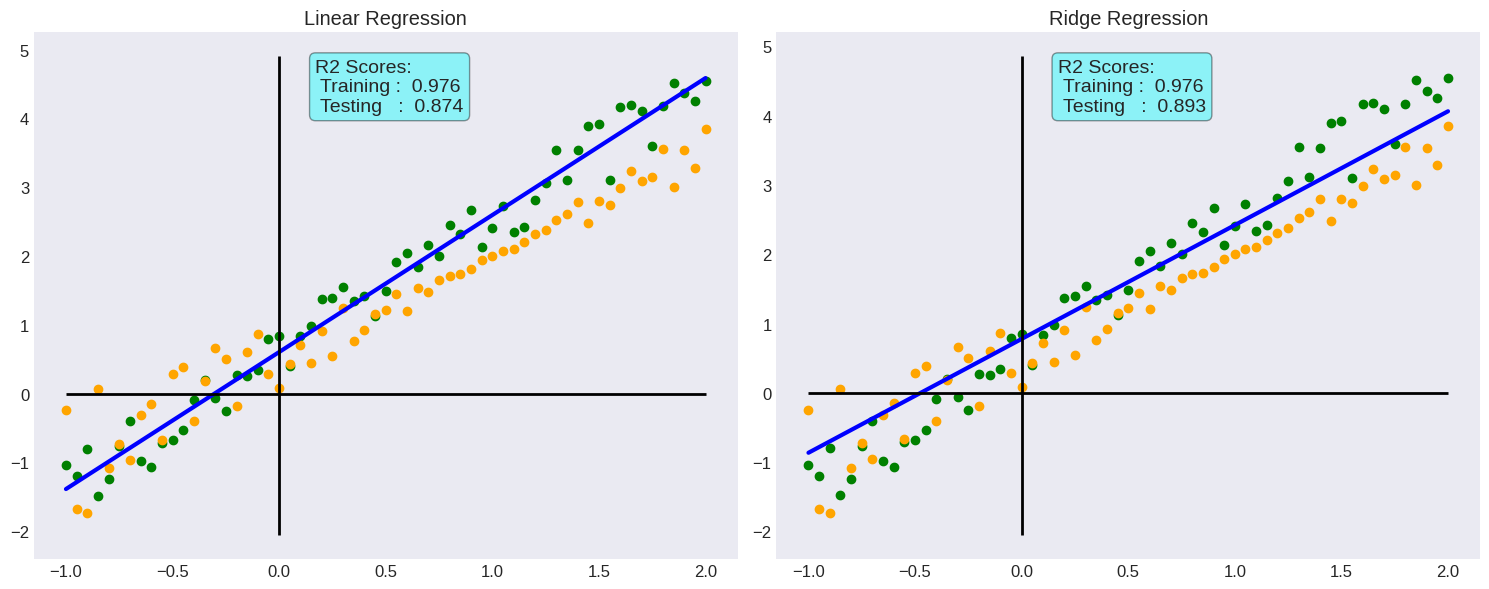

In [23]:
fig, axes = plt.subplots(1,2, figsize = (15,6))

colors = CMAP(np.linspace(0,1,4))

ax = axes[0]
y_pred = lr.predict(X_test.reshape(-1, 1))
ax.plot(X_test,y_hat , color = 'b', lw = 3)
ax.scatter(X_train, y_train, color = 'g')
ax.scatter(X_test, y_test, color = 'Orange')
fn_beautify_plot(ax, y_hat)
ax.set_title('Linear Regression')


ax = axes[1]
y_pred = ridge.predict(X_test.reshape(-1, 1))
ax.plot(X_test,y_pred , color = 'b', lw = 3)
ax.scatter(X_train, y_train, color = 'g')
ax.scatter(X_test, y_test, color = 'Orange')
fn_beautify_plot(ax, y_pred)
ax.set_title('Ridge Regression')

plt.tight_layout()
plt.show()

### Boston Housing Dataset


The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per 10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

In [24]:
dataDir = 'boston_housing'

dataFile = 'boston_house_price.csv'

dataPath = os.path.join(inpDir, dataDir, dataFile)

In [25]:
data_df = pd.read_csv(dataPath)

data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [26]:
data_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [27]:
data_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


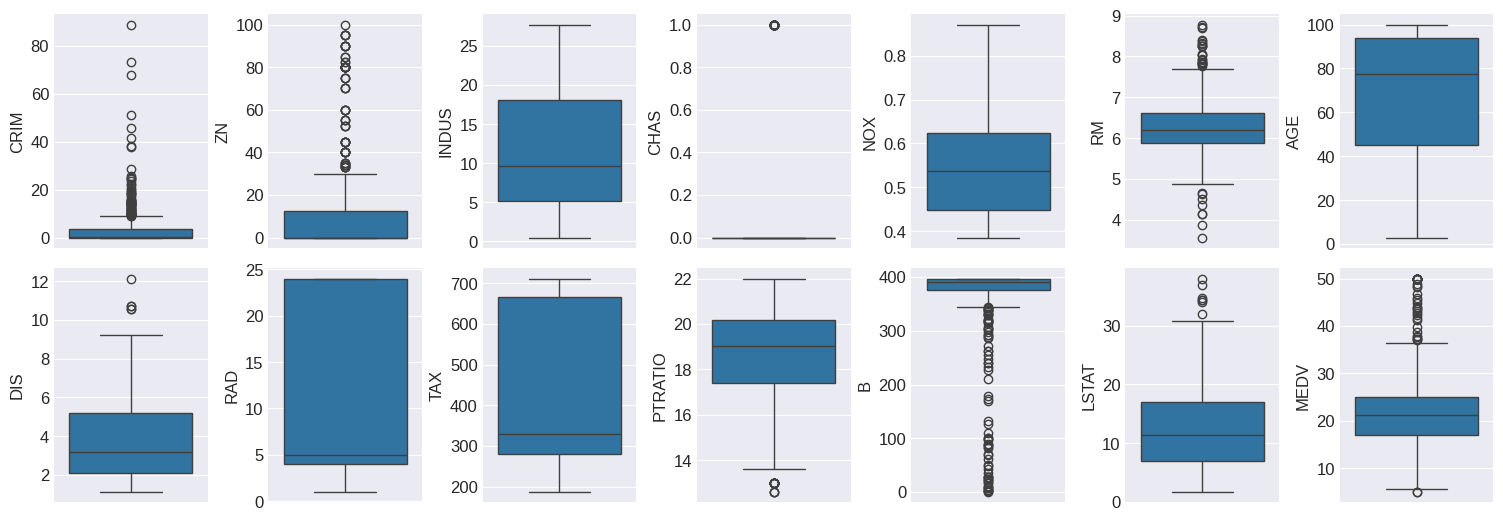

In [29]:
fig, axes = plt.subplots(ncols=7, nrows=2)

axes = axes.flatten()

for count, col in enumerate(data_df.columns):
    ax=axes[count]
    sns.boxplot(y=col, data=data_df,ax=ax , saturation=0.75,)
    
plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=1)

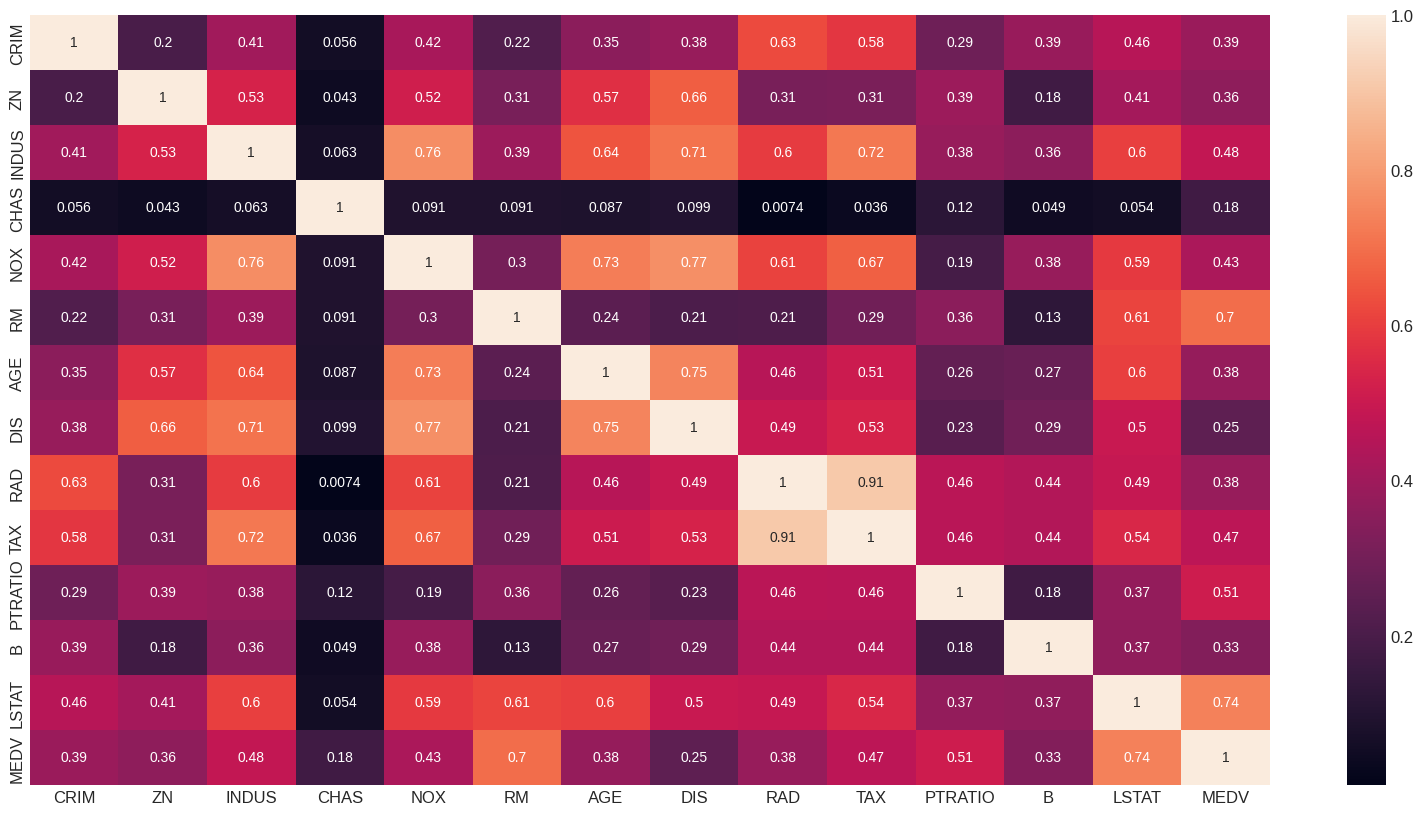

In [30]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_df.corr().abs(),  annot=True);

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.4 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV.

In [31]:
#selected_cols = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
selected_cols = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX']

y = data_df['MEDV']

data_df = data_df[selected_cols].copy()

In [32]:
# using original dataset for splitting

X_train, X_test, y_train, y_test = train_test_split(data_df, y, random_state=RANDOM_STATE)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((379, 6), (127, 6), (379,), (127,))

In [34]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# lets print Linear Regression results
print ('Train R2 Score: {:7.4f}'.format(lr.score(X_train, y_train)))
print ('Test R2 Score : {:7.4f}'.format(lr.score(X_test, y_test)))

Train R2 Score:  0.6984
Test R2 Score :  0.6119


In [35]:
ridge = Ridge()

ridge.fit(X_train, y_train)

# lets print Linear Regression results
print ('Train R2 Score: {:7.4f}'.format(ridge.score(X_train, y_train)))
print ('Test R2 Score : {:7.4f}'.format(ridge.score(X_test , y_test )))

Train R2 Score:  0.6956
Test R2 Score :  0.6160


In [36]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Train set score: {:7.4f}".format(ridge10.score(X_train, y_train)))
print("Test  set score: {:7.4f}".format(ridge10.score(X_test, y_test)))

Train set score:  0.6254
Test  set score:  0.5594


In [37]:
reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10, 100], cv = 5).fit(X_train, y_train)
reg.score(X_test, y_test)

0.6160158433737983

In [38]:
reg.get_params()

{'alpha_per_target': False,
 'alphas': [0.001, 0.01, 0.1, 1, 5, 10, 100],
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_values': False}

### K-Fold with cross validation score

In [39]:
kf = KFold(n_splits=10)

lr = LinearRegression()

scores = cross_val_score(lr, 
                         X_train, y_train, 
                         cv=kf, 
                         scoring='neg_mean_squared_error')


print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -28.09 (+/- 8.48)


In [40]:
kf = KFold(n_splits=10)

ridge = Ridge()

scores = cross_val_score(ridge, 
                         X_train, y_train, 
                         cv=kf, 
                         scoring='neg_mean_squared_error')


print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -28.21 (+/- 8.83)


In [41]:
model = make_pipeline(PolynomialFeatures(degree=3), 
                      Ridge())
kf = KFold(n_splits=10)

scores = cross_val_score(model, 
                         X_train, y_train, 
                         cv=kf, 
                         scoring='neg_mean_squared_error')


print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -16.92 (+/- 9.60)


## Lasso

Lasso and Ridge are similar but there is minor difference.

The lasso also restricts coefficients to be close to zero, but using L1 regularization. The consequence of L1 regularization
is that when using the lasso, some coefficients are exactly zero. This means some features are entirely ignored by the model. This can be seen as a form of automatic feature selection. Having some coefficients be exactly zero often makes a model easier to interpret, and can reveal the most important features of your model.

$\lambda$ is learning rate (constant that multiplies the L1 term, controlling regularization strength). $\alpha$ must be a non-negative float i.e. in [0, inf).

for single variable 
- Hypothesis : $h_\theta(x) = \theta_0 * x_0 + \theta_1 * x_1$
- Parameters : $\theta_0 , \theta_1, \lambda$
- Cost Function : $J_\theta(h_\theta(x), y) = \frac{1}{2*m}\sum_{i=1}^m[h_\theta(x^i) -y^i]^2 + |\lambda * (\theta_1)|$
- Goal : Minimize $J_\theta(h_\theta(x), y)$

When $\lambda$ = 0, the objective is equivalent to ordinary least squares, solved by the LinearRegression object. For numerical reasons, using $\lambda$ = 0 with the Lasso object is not advised. Instead, you should use the LinearRegression object.

### Comparison
Ridge regression works better where all features are contributing towards results. Lasso does better if you suspect irrelevant features. 

Let's apply the lasso to the extended Boston Housing dataset:

In [42]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)

print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))

print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))

print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.27
Test set score: 0.25
Number of features used: 2


Not doing well...

We can understand as default $\alpha$ is 1.0. We can experiment with $\alpha$ to optimize the results.

In [43]:
# increase the default setting of "max_iter", otherwise the model would warn us that we should increase max_iter.

lasso1 = Lasso(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(lasso1.score(X_train, y_train)))

print("Test set score: {:.2f}".format(lasso1.score(X_test, y_test)))

print("Number of features used: {}".format(np.sum(lasso1.coef_ != 0)))

Training set score: 0.69
Test set score: 0.61
Number of features used: 4


In [44]:
# increase the default setting of "max_iter", otherwise the model would warn us that we should increase max_iter.

lasso01 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(lasso01.score(X_train, y_train)))

print("Test set score: {:.2f}".format(lasso01.score(X_test, y_test)))

print("Number of features used: {}".format(np.sum(lasso01.coef_ != 0)))

Training set score: 0.70
Test set score: 0.61
Number of features used: 6


A lower alpha allowed us to fit a more complex model, which worked better on the
training and test data. The performance is slightly better than using Ridge.

In [45]:
kf = KFold(n_splits=10)

lassocv = Lasso(alpha=0.01, max_iter=100000)

scores = cross_val_score(lassocv, 
                         X_train, y_train, 
                         cv=kf, 
                         scoring='neg_mean_squared_error')


print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -28.03 (+/- 8.46)


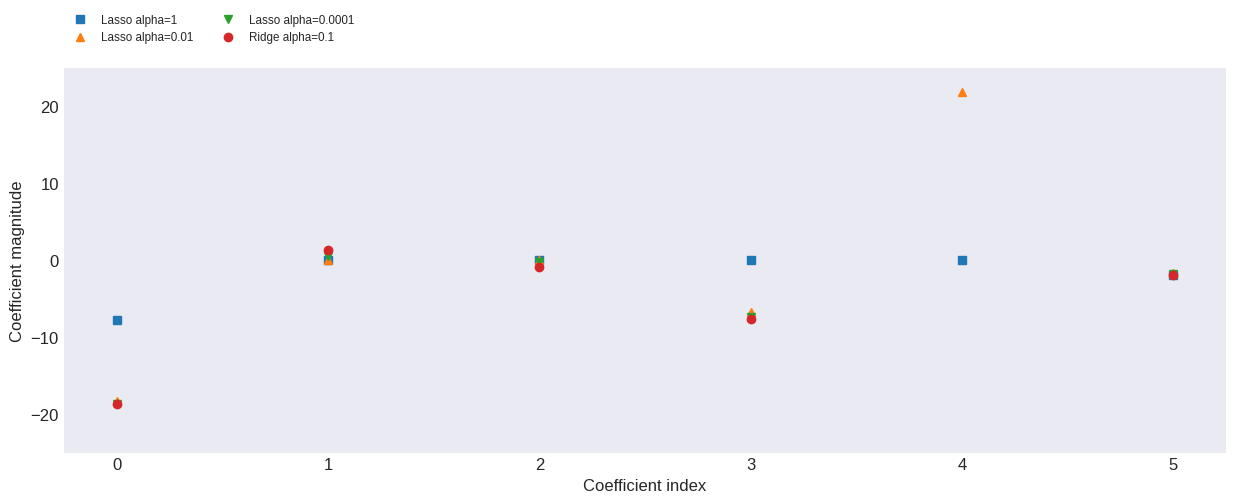

In [46]:
fig, ax = plt.subplots()
ax.plot(lasso.coef_, 's', label="Lasso alpha=1")
ax.plot(lasso1.coef_, '^', label="Lasso alpha=0.01")
ax.plot(lasso01.coef_, 'v', label="Lasso alpha=0.0001")

ridge = Ridge(alpha=0.1).fit(X_train, y_train)

ax.plot(ridge.coef_, 'o', label="Ridge alpha=0.1")
ax.legend(ncol=2, loc=(0, 1.05))
ax.set_ylim(-25, 25)
ax.set_xlabel("Coefficient index")
ax.set_ylabel("Coefficient magnitude")

ax.grid()
plt.show();

## Elastic Net Regression

- Lasso works best if there are lot of **useless** (*irrelevant*) features.
- Ridge regression works best of there are lots of **useful** (*relevant*) features.

- What if we have millions of parameters? Practically impossible to keep track.

Elastic Net combines properties of both Lasso as well as Ridge Regression.

for single variable 
- Hypothesis : $h_\theta(x) = \theta_0 * x_0 + \theta_1 * x_1$
- Parameters : $\theta_0 , \theta_1, \lambda_1, \lambda_2$
- Cost Function : $J_\theta(h_\theta(x), y) = \frac{1}{2*m}\sum_{i=1}^m[h_\theta(x^i) -y^i]^2 + |\lambda_1 * \theta_1| + \lambda_2 * (\theta_1)^2$
- Goal : Minimize $J_\theta(h_\theta(x), y)$

Use cross validation on both $\lambda_1$ and $\lambda_2$ find best values.

In [47]:
reg = ElasticNet(random_state=RANDOM_STATE)

reg.fit(X_train, y_train)

ElasticNet(random_state=24)

In [48]:
# lets print results
print ('Train R2 Score: {:7.4f}'.format(reg.score(X_train, y_train)))
print ('Test R2 Score : {:7.4f}'.format(reg.score(X_test , y_test )))

Train R2 Score:  0.1510
Test R2 Score :  0.1316
